# SHAP Values for XGB With All Age Data

In [1]:
%pwd

'/home/GPU/ML_GallupWellBeingResearch/Code'

In [2]:
%cd ..

/home/GPU/ML_GallupWellBeingResearch


/home/GPU/miniconda3/envs/rapids-24.06/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
from joblib import dump, load
import os 
import pandas as pd
#import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [4]:
xgb.__version__

'2.0.3'

In [5]:
from cuml.explainer import KernelExplainer

In [6]:
import cudf

In [7]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

## SHAP 

### load data and hyperparameter

In [8]:
hyper_dict = {'gamma': 0.001035679916752757,
 'learning_rate': 0.030918808165467035,
 'max_delta_step': 0.3824267566556339,
 'max_depth': 11,
 'min_child_weight': 0.16747411396464854,
 'n_estimators': 2441,
 'reg_alpha': 1.1240879648711004,
 'reg_lambda': 0.006725578387643221,
 'subsample': 0.653416651975892}

In [9]:
Df_Filename = os.path.join("Data", "GallupWB_Ml64var1911k14wave_v1.parquet")

In [10]:
Df = pd.read_parquet(Df_Filename)

In [11]:
#Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')
label_encoder = LabelEncoder()
Df['COUNTRY_ISO3'] = label_encoder.fit_transform(Df['COUNTRY_ISO3'])

In [12]:
Df['COUNTRY_ISO3'].describe()

count    1.911212e+06
mean     7.819511e+01
std      4.666500e+01
min      0.000000e+00
25%      3.800000e+01
50%      7.400000e+01
75%      1.180000e+02
max      1.630000e+02
Name: COUNTRY_ISO3, dtype: float64

In [13]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
ytot = Df['Cantril_ladder']

In [15]:
Xtot = Df.drop(columns=['Cantril_ladder'])

### Shap Computation

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [18]:
Shap_df = []

i = 1
for train_index, test_index in kf.split(Xtot):
    print(f"This is {i} fold")
    X_train, X_test = Xtot.iloc[train_index, :], Xtot.iloc[test_index, :]
    y_train, y_test = ytot.iloc[train_index], ytot.iloc[test_index]
    print(X_test.iloc[:100,:].shape)

    cX_train = cudf.from_pandas(X_train)
    cX_test = cudf.from_pandas(X_test)
    cy_train = cudf.from_pandas(y_train)
    cy_test = cudf.from_pandas(y_test)
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42, device = 'cuda', **hyper_dict)
    model.fit(cX_train, cy_train)
    
    print('model done')

    colnames = X_test.columns + '_shap'

    background = cudf.from_pandas(X_train.iloc[:100,:])
    cu_explainer = KernelExplainer(model=model.predict,
                                   data=background,
                                   is_gpu_model=True, random_state=42)
    
    interval = 1000
    for row in list(range(10_000, 120_000, interval)):
        print(f'here{row}:{row + interval}')
        %time cu_shap_value_merge = cu_explainer.shap_values(X_test.iloc[row:row + interval,:])
        X_test_shap = pd.DataFrame(cu_shap_value_merge, columns=colnames, index=X_test.index[row:row + interval])
        X_test_merge = pd.concat([y_test.iloc[row:row + interval], X_test.iloc[row:row + interval,:], X_test_shap], axis=1)

        X_test_merge.to_parquet(f'Results/ShapAll_120k/X_test_{row}_{row + interval}.parquet')
        Shap_df.append(X_test_merge)

    dump(Shap_df, "Results/Shap_TotalDataset_120k.joblib")
    break

This is 1 fold
(100, 63)


/home/GPU/miniconda3/envs/rapids-24.06/lib/python3.9/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


model done
here10000:11000
CPU times: user 24min 43s, sys: 11.9 s, total: 24min 55s
Wall time: 9min 19s
here11000:12000
CPU times: user 24min 52s, sys: 11.9 s, total: 25min 4s
Wall time: 9min 19s
here12000:13000
CPU times: user 24min 43s, sys: 11.7 s, total: 24min 55s
Wall time: 9min 20s
here13000:14000
CPU times: user 24min 49s, sys: 11.8 s, total: 25min
Wall time: 9min 20s
here14000:15000
CPU times: user 24min 54s, sys: 11.8 s, total: 25min 6s
Wall time: 9min 21s
here15000:16000
CPU times: user 24min 46s, sys: 11.6 s, total: 24min 58s
Wall time: 9min 19s
here16000:17000
CPU times: user 24min 45s, sys: 11.6 s, total: 24min 57s
Wall time: 9min 19s
here17000:18000
CPU times: user 24min 44s, sys: 11.5 s, total: 24min 55s
Wall time: 9min 19s
here18000:19000
CPU times: user 25min 1s, sys: 11.8 s, total: 25min 13s
Wall time: 9min 22s
here19000:20000
CPU times: user 24min 52s, sys: 11.4 s, total: 25min 3s
Wall time: 9min 20s
here20000:21000
CPU times: user 24min 53s, sys: 11.9 s, total: 25mi

In [19]:
Concat_Shap = pd.concat(Shap_df, axis=0)

In [20]:
Concat_Shap.shape

(1911212, 127)

In [22]:
Concat_Shap.columns

Index(['Cantril_ladder', 'wave', 'INCOME_2', 'Health_disable', 'Relative_have',
       'Living_standard_change', 'Enough_food', 'Enough_shelter',
       'Well_rested', 'Respected',
       ...
       'Corruption_government_shap', 'Performance_leadership_shap',
       'Gender_female_shap', 'Age_shap', 'Marital_status_shap',
       'Employment_shap', 'Children_under15_shap', 'Feeling_income_shap',
       'Income_level_shap', 'COUNTRY_ISO3_shap'],
      dtype='object', length=127)

### Draw Plot of Age

In [4]:
Shap_df = load("Results/Shap_TotalDataset.joblib")

In [5]:
Concat_Shap = pd.concat(Shap_df, axis=0)

In [7]:
Concat_Shap.shape

(1911212, 127)

In [12]:
#Concat_Shap.to_parquet("Results/Shap_TotalDatasetTreeEplain.parquet")

In [11]:
sorted(Concat_Shap['Age_shap'].unique())

[-0.124694675,
 -0.115843564,
 -0.10764524,
 -0.096717134,
 -0.0953448,
 -0.09152395,
 -0.07808477,
 -0.07709958,
 -0.07202862,
 -0.06983307,
 -0.068805225,
 -0.06774917,
 -0.066160336,
 -0.06567106,
 -0.06270729,
 -0.049408544,
 -0.04351601,
 -0.042899374,
 -0.0401199,
 -0.03655449,
 -0.026123503,
 -0.0040100887,
 0.0035142554,
 0.0035751336,
 0.0152991,
 0.015776563,
 0.016043244,
 0.01662778,
 0.023073712,
 0.02431558,
 0.025328545,
 0.028254567,
 0.030908678,
 0.036854308,
 0.038859017,
 0.06491261,
 0.06526296,
 0.06938681,
 0.08033723,
 0.08868406,
 0.08889696,
 0.0918609,
 0.11063762,
 0.11184761,
 0.11351052,
 0.17558543,
 nan,
 0.11346496,
 0.1377993,
 0.1970437,
 0.3454863]

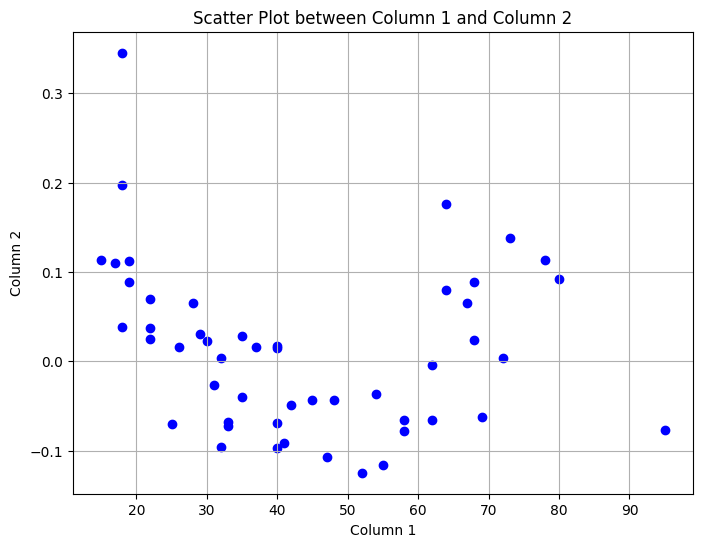

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(Concat_Shap['Age'], Concat_Shap['Age_shap'], color='blue')
plt.title('Scatter Plot between Column 1 and Column 2')
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.grid(True)
plt.show()